In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
import datetime
import seaborn as sns 
import pandas as pd


In [2]:
def is_random_concept(concept, random_counterpart=None, random_concepts=None):
        if random_counterpart:
            return random_counterpart == concept

        elif random_concepts:
            return concept in random_concepts

        else:
            return 'random500_' in concept

def get_results_summary(results):
    result_summary = {}
    random_i_ups = {}

    for result in results:
        
        if result['cav_concept'] not in result_summary:
            result_summary[result['cav_concept']] = {}
        if result['bottleneck'] not in result_summary[result['cav_concept']]:
            result_summary[result['cav_concept']][result['bottleneck']] = []

        result_summary[result['cav_concept']][result['bottleneck']].append(result)

        if is_random_concept(result['cav_concept']):
            if result['bottleneck'] not in random_i_ups:
                random_i_ups[result['bottleneck']] = []

            random_i_ups[result['bottleneck']].append(result['i_up'])

    return result_summary, random_i_ups

def present_results(result_summary, random_i_ups, min_p_val=0.05):
    for concept in result_summary:

        # if not random
        if not is_random_concept(concept):
            print(" ", "Concept =", concept)

            for bottleneck in result_summary[concept]:
                i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]

                # Calculate statistical significance
                _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)

                print(3 * " ", "Bottleneck =", ("%s. TCAV Score = %.2f (+- %.2f), "
                                                "random was %.2f (+- %.2f). p-val = %.3f (%s)") % (
                        bottleneck, np.mean(i_ups), np.std(i_ups),
                        np.mean(random_i_ups[bottleneck]),
                        np.std(random_i_ups[bottleneck]), p_val,
                        "not significant" if p_val > min_p_val else "significant"))

In [3]:
# Load the TCAV results
RESULTS_PATH = '../../data/TCAV results/tcav_results_left_performed_tuh.pkl'
with open(RESULTS_PATH, 'rb') as f:
    results = pickle.load(f)

In [4]:
print(results[0]['target_class'])

result_summary, random_i_ups = get_results_summary(results)
present_results(result_summary, random_i_ups);

Left fist, performed
  Concept = Alpha_Dorsal Stream Visual Cortex-lh
    Bottleneck = encoder. TCAV Score = 0.41 (+- 0.35), random was 0.48 (+- 0.38). p-val = 0.413 (not significant)
    Bottleneck = enc_augment. TCAV Score = 0.47 (+- 0.34), random was 0.52 (+- 0.43). p-val = 0.580 (not significant)
    Bottleneck = summarizer. TCAV Score = 0.54 (+- 0.36), random was 0.50 (+- 0.44). p-val = 0.590 (not significant)
    Bottleneck = extended_classifier. TCAV Score = 0.68 (+- 0.47), random was 0.48 (+- 0.50). p-val = 0.056 (not significant)
    Bottleneck = classifier. TCAV Score = 0.88 (+- 0.32), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
  Concept = Alpha_Dorsal Stream Visual Cortex-rh
    Bottleneck = encoder. TCAV Score = 0.76 (+- 0.19), random was 0.48 (+- 0.38). p-val = 0.000 (significant)
    Bottleneck = enc_augment. TCAV Score = 0.56 (+- 0.35), random was 0.52 (+- 0.43). p-val = 0.667 (not significant)
    Bottleneck = summarizer. TCAV Score = 0.53 (+- 0.37), random 

/tmp/ipykernel_10285/2623841600.py:43: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)


In [5]:
random_i_ups.keys()

dict_keys(['encoder', 'enc_augment', 'summarizer', 'extended_classifier', 'classifier'])

In [6]:
min_p_value = 0.05

for concept in result_summary:

    # if not random
    if not is_random_concept(concept):
        print(" ", "Concept =", concept)

        for bottleneck in result_summary[concept]:
            i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]

            # Calculate statistical significance
            _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)

            print(3 * " ", "Bottleneck =", ("%s. TCAV Score = %.2f (+- %.2f), "
                                            "random was %.2f (+- %.2f). p-val = %.3f (%s)") % (
                    bottleneck, np.mean(i_ups), np.std(i_ups),
                    np.mean(random_i_ups[bottleneck]),
                    np.std(random_i_ups[bottleneck]), p_val,
                    "not significant" if p_val > min_p_value else "significant"))

  Concept = Alpha_Dorsal Stream Visual Cortex-lh
    Bottleneck = encoder. TCAV Score = 0.41 (+- 0.35), random was 0.48 (+- 0.38). p-val = 0.413 (not significant)
    Bottleneck = enc_augment. TCAV Score = 0.47 (+- 0.34), random was 0.52 (+- 0.43). p-val = 0.580 (not significant)
    Bottleneck = summarizer. TCAV Score = 0.54 (+- 0.36), random was 0.50 (+- 0.44). p-val = 0.590 (not significant)
    Bottleneck = extended_classifier. TCAV Score = 0.68 (+- 0.47), random was 0.48 (+- 0.50). p-val = 0.056 (not significant)
    Bottleneck = classifier. TCAV Score = 0.88 (+- 0.32), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
  Concept = Alpha_Dorsal Stream Visual Cortex-rh
    Bottleneck = encoder. TCAV Score = 0.76 (+- 0.19), random was 0.48 (+- 0.38). p-val = 0.000 (significant)
    Bottleneck = enc_augment. TCAV Score = 0.56 (+- 0.35), random was 0.52 (+- 0.43). p-val = 0.667 (not significant)
    Bottleneck = summarizer. TCAV Score = 0.53 (+- 0.37), random was 0.50 (+- 0.44). p

/tmp/ipykernel_10285/1964557675.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)


    Bottleneck = extended_classifier. TCAV Score = 0.64 (+- 0.48), random was 0.48 (+- 0.50). p-val = 0.129 (not significant)
    Bottleneck = classifier. TCAV Score = 0.92 (+- 0.27), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
  Concept = Alpha_Early Visual Cortex-lh
    Bottleneck = encoder. TCAV Score = 0.06 (+- 0.17), random was 0.48 (+- 0.38). p-val = 0.000 (significant)
    Bottleneck = enc_augment. TCAV Score = 0.41 (+- 0.36), random was 0.52 (+- 0.43). p-val = 0.228 (not significant)
    Bottleneck = summarizer. TCAV Score = 0.49 (+- 0.39), random was 0.50 (+- 0.44). p-val = 0.917 (not significant)
    Bottleneck = extended_classifier. TCAV Score = 0.76 (+- 0.43), random was 0.48 (+- 0.50). p-val = 0.007 (significant)
    Bottleneck = classifier. TCAV Score = 0.84 (+- 0.37), random was 0.50 (+- 0.50). p-val = 0.001 (significant)
  Concept = Alpha_Early Visual Cortex-rh
    Bottleneck = encoder. TCAV Score = 0.73 (+- 0.16), random was 0.48 (+- 0.38). p-val = 0.001 (si

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

def plot_results(result_summary, random_i_ups, min_p_val=0.05):

    TITLE_SIZE = 32
    LABEL_SIZE = 24
    TICK_SIZE = 18

    fig, ax = plt.subplots(figsize=(32, 8))

    # get the results in a format that can be used for plotting
    results_df = pd.DataFrame(columns=['Concept', 'Bottleneck', 'TCAV Score', 'Random TCAV Score', 'p-value', 'Significant'])
    for concept in result_summary:
        # if not random
        if not is_random_concept(concept):
            for bottleneck in result_summary[concept]:
                i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]
                # Calculate statistical significance
                #_, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)
                _, p_val = mannwhitneyu(random_i_ups[bottleneck], i_ups)
                # Explicitly cast 'Significant' to bool dtype
                significant = p_val <= min_p_val
                results_df = pd.concat([results_df, pd.DataFrame({'Concept': concept, 'Bottleneck': bottleneck, 'TCAV Score': np.mean(i_ups), 'Random TCAV Score': np.mean(random_i_ups[bottleneck]), 'p-value': p_val, 'Significant': significant}, index=[0])], ignore_index=True)

    

    # get bar width
    ax = sns.barplot(x="Concept", y="TCAV Score", hue="Bottleneck", data=results_df)
    bar_width = ax.patches[0].get_width()

    bottleneck_placements = [-2*bar_width, -bar_width, 0, bar_width, 2*bar_width]
    # Add stars above the bars for statistical significance
    for i, concept in enumerate(result_summary):
        if not is_random_concept(concept):
            for j, bottleneck in enumerate(result_summary[concept]):
                significant = results_df.loc[(results_df['Concept'] == concept) & (results_df['Bottleneck'] == bottleneck), 'Significant'].values[0]
                
                if significant:
                    x = i + bottleneck_placements[j]
                    y = np.max(results_df.loc[(results_df['Concept'] == concept) & (results_df['Bottleneck'] == bottleneck), 'TCAV Score']) - 0.01
                    plt.text(x, y, '*', ha='center', va='bottom', fontsize=20, fontweight='bold', color='black')

    # plot the results
    sns.set_theme(style="whitegrid")
    plt.xticks(rotation=80)
    # Move all xticks 0.5 to the right
    plt.gca().xaxis.set_tick_params(pad=-1.5)

    plt.title('TCAV results', fontsize=TITLE_SIZE)
    plt.xlabel('Concept', fontsize=LABEL_SIZE)
    plt.ylabel('TCAV Score', fontsize=LABEL_SIZE)
    plt.tick_params(axis='both', which='major', labelsize=TICK_SIZE)


    plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", borderaxespad=0, fontsize=LABEL_SIZE)
    

    plt.show()

    return results_df


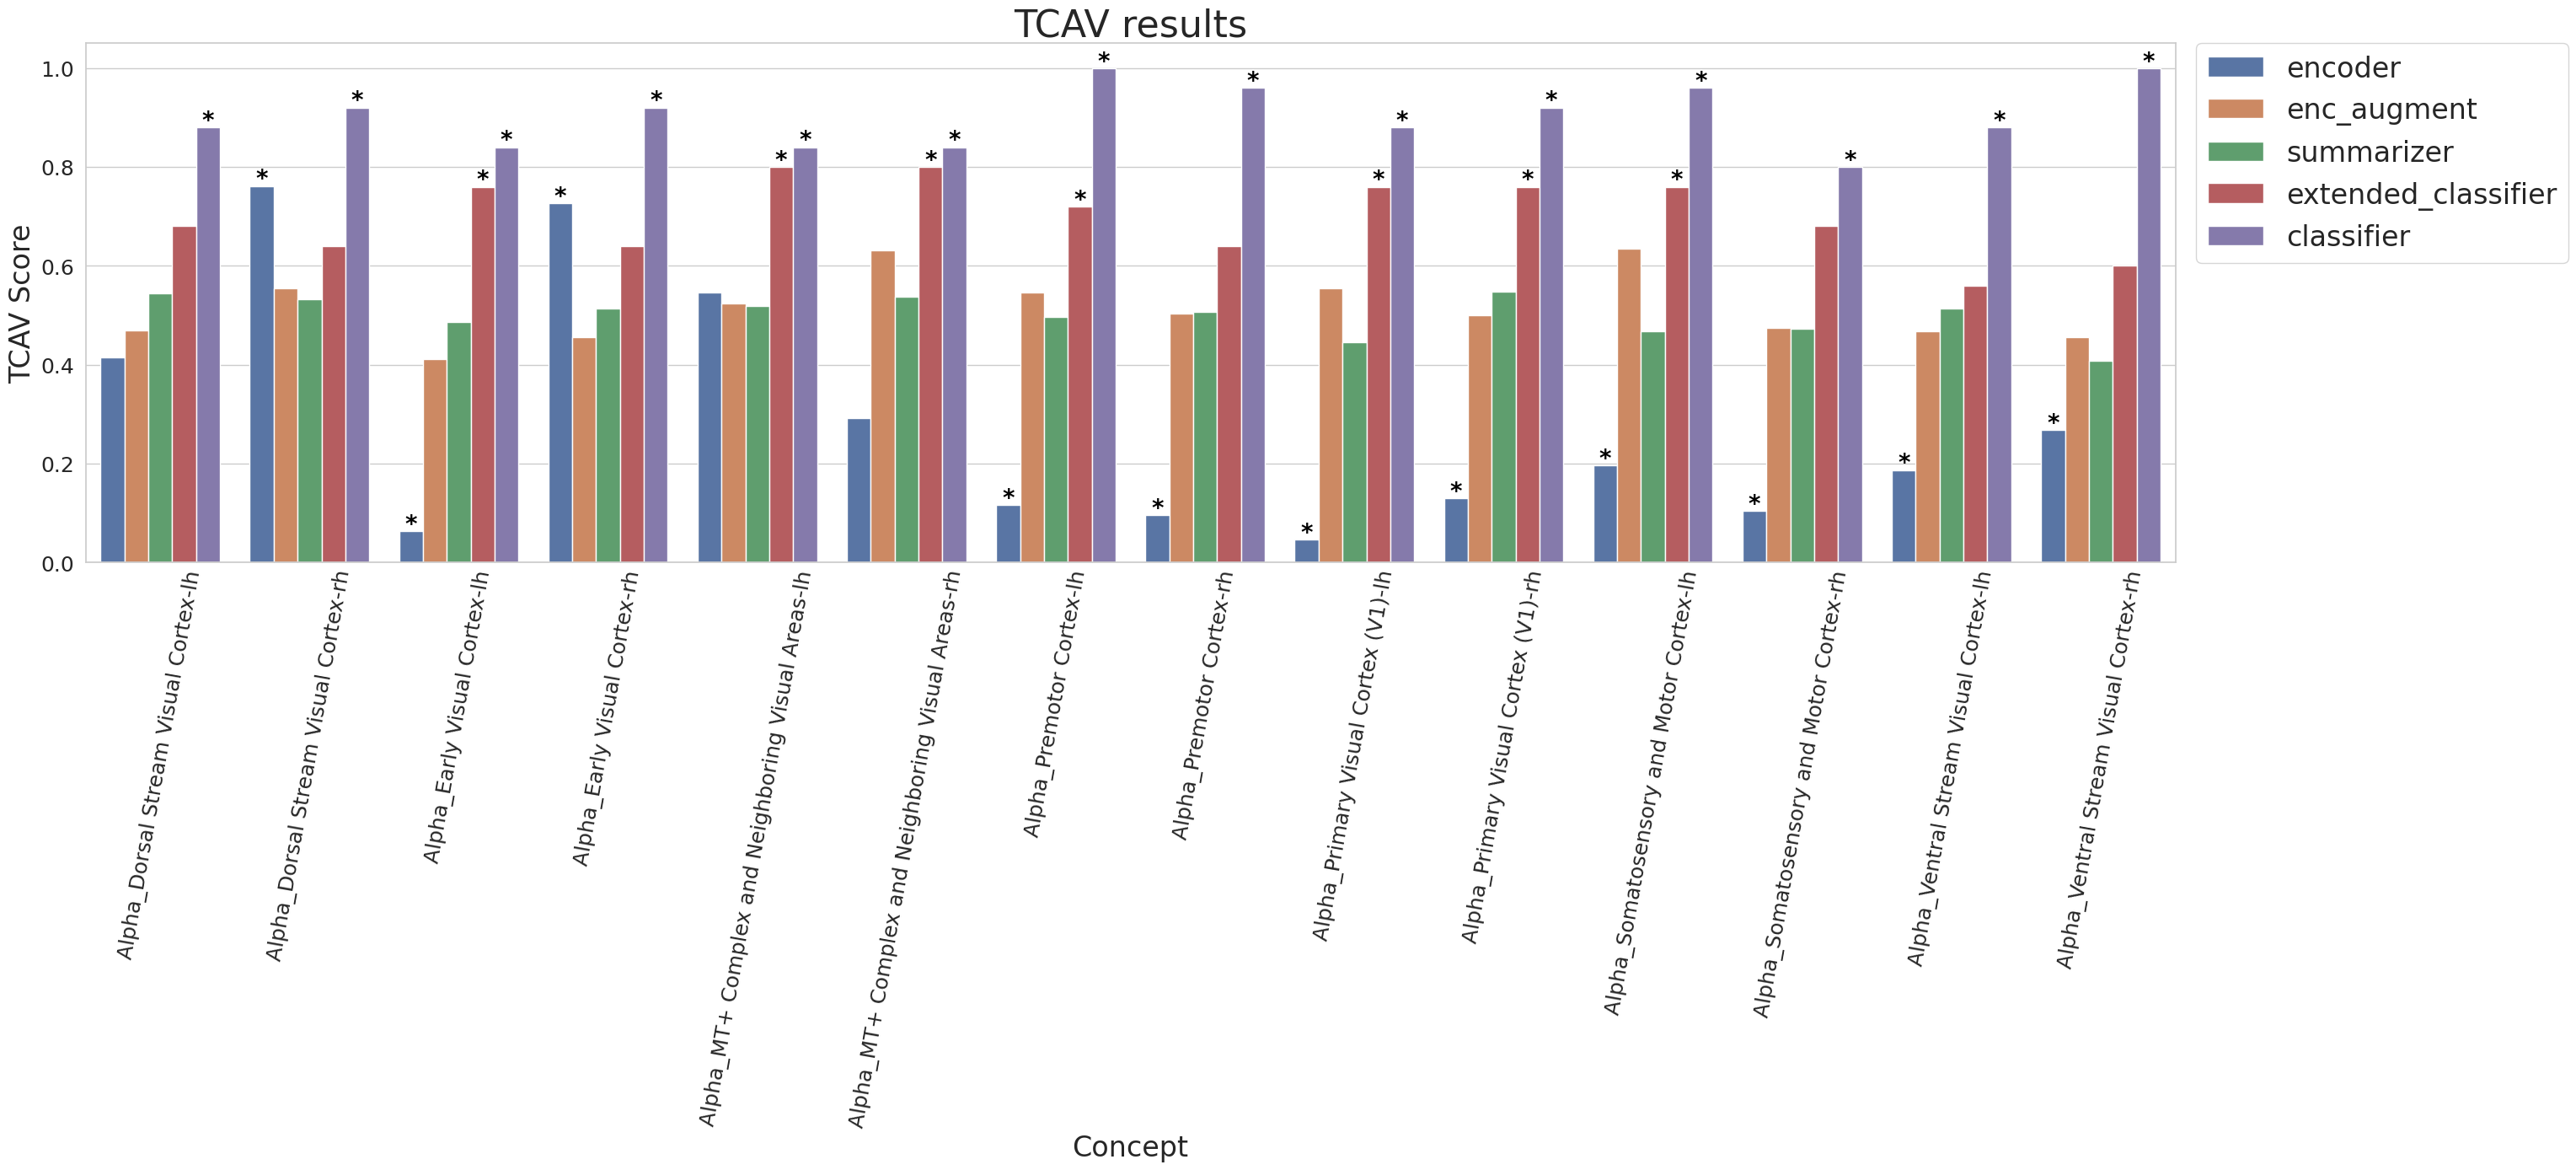

,Concept,Bottleneck,TCAV Score,Random TCAV Score,p-value,Significant
0,Alpha_Dorsal Stream Visual Cortex-lh,encoder,0.4144,0.478467,0.452505,False
1,Alpha_Dorsal Stream Visual Cortex-lh,enc_augment,0.4688,0.517400,0.476537,False
2,Alpha_Dorsal Stream Visual Cortex-lh,summarizer,0.5440,0.495733,0.668994,False
3,Alpha_Dorsal Stream Visual Cortex-lh,extended_classifier,0.6800,0.485000,0.056311,False
4,Alpha_Dorsal Stream Visual Cortex-lh,classifier,0.8800,0.501667,0.000211,True
...,...,...,...,...,...,...
65,Alpha_Ventral Stream Visual Cortex-rh,encoder,0.2688,0.478467,0.028184,True
66,Alpha_Ventral Stream Visual Cortex-rh,enc_augment,0.4560,0.517400,0.571502,False
67,Alpha_Ventral Stream Visual Cortex-rh,summarizer,0.4080,0.495733,0.458644,False
68,Alpha_Ventral Stream Visual Cortex-rh,extended_classifier,0.6000,0.485000,0.260397,False


In [37]:
plot_results(result_summary, random_i_ups)